# Imports

In [128]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Parameters

In [130]:
# Num Image Channels
nc = 3


# Size of feature maps in discriminator
ndf = 96

# Size of feature maps in generator
ngf = 96

# Batch Size
batch_size = 64

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Load the Dataset

In [131]:
# Create a new transformation that resizes the images

# Create a new transformation that resizes the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load STL-10 dataset
train_dataset = STL10(root='./data', split='train', transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


# Model Definition

In [132]:
class Encoder(nn.Module):
    def __init__(self, ngpu, dim_z, num_classes):
        super(Encoder, self).__init__()
        self.ngpu = ngpu
        nc = 3  # Number of input channels for the 96x96x3 image
        self.main = nn.Sequential(
            # input is (nc) x 96 x 96
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf) x 48 x 48
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*2) x 24 x 24
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*4) x 12 x 12
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*8) x 6 x 6
            nn.Conv2d(ndf * 8, dim_z, 6, 1, 0, bias=False)
        )
        self.fc = nn.Linear(dim_z, num_classes)

    def forward(self, input):
        z = self.main(input)
        z = z.view(input.size(0), -1)  # Flatten z to (batch_size, dim_z)
        c = self.fc(z)
        return c

# Load Finetuned Weights

In [133]:
model = Encoder(ngpu=0, dim_z=64, num_classes=10).to(device)
PATH='finetuned_encoder_weights_da_0.0001_128_0.0004.pth'
model.main.load_state_dict(torch.load(PATH))
model

Encoder(
  (main): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(192, 384, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(384, 768, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(768, 64, kernel_size=(6, 6), stride=(1, 1), bias=False)
  )
  (fc): Linear(in_features=64, out_features=10, bias=True

# Running the Model

true label- ship
predicted label- ship


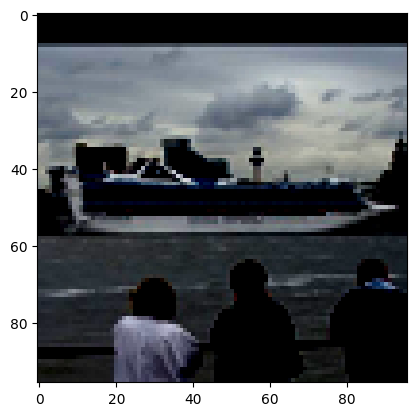

In [174]:
for images, labels in train_loader:
    data = images[0]
    label = labels[0]
    break  
    
class_names = ["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]
image = data.numpy().transpose((1, 2, 0))
image = np.clip(image, 0, 1)
plt.imshow(image)
print(f'true label- {class_names[label]}')




model.eval()
pred = ''
with torch.no_grad():
    data = data.unsqueeze(0) 
    data = data.to(device)

    out = model(data)
    pred = class_names[torch.argmax(out.data, dim=1).item()]

print(f'predicted label- {pred}')

In [175]:
model_weights = []
conv_layers = []
model_children = list(model.main.children())  

counter = 0
for i in range(len(model_children)):
    if isinstance(model_children[i], nn.Conv2d):
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])

print(f"Total convolution layers: {counter}")

Total convolution layers: 5


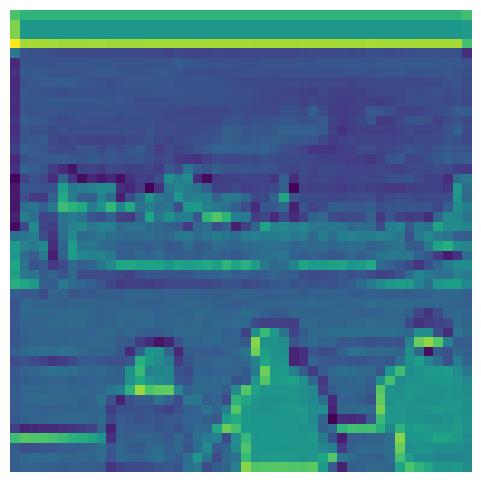

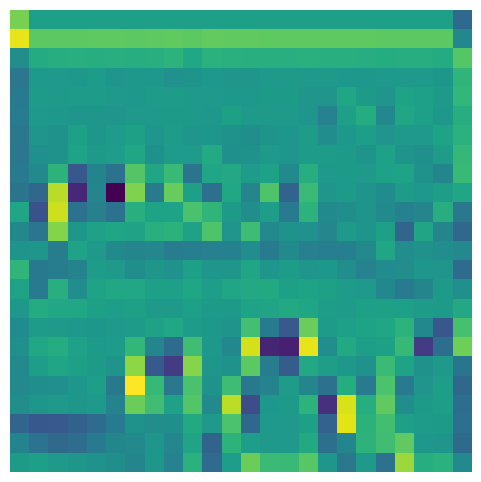

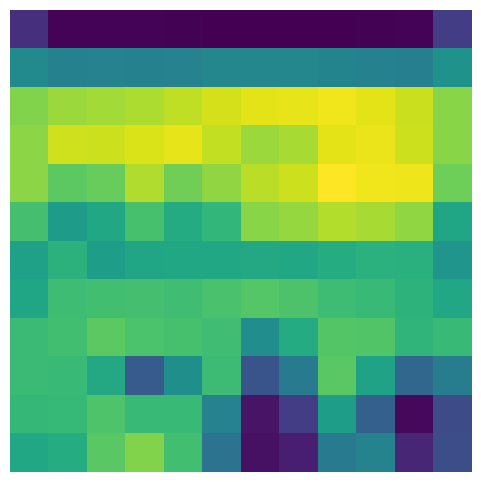

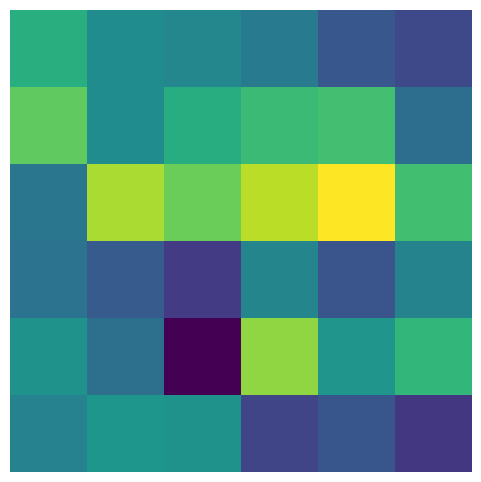

In [176]:
import matplotlib.pyplot as plt

data = data.squeeze(0)  
data = data.squeeze(-1)  

outputs = []


for layer in conv_layers:
    data = layer(data)
    outputs.append(data)

num_layers = len(outputs)-1

for idx in range(num_layers):
    fm_numpy = outputs[idx].squeeze(0).detach().cpu().numpy()
    plt.figure(figsize=(6, 6))
    plt.imshow(fm_numpy[0], cmap='viridis')
    plt.axis('off')
    plt.show()